In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# read the half hourly data for all the seasons (3 towers with 9 seasons)
USUC1_path = os.path.join(os.getcwd(), 'AMF_US-UC1_BASE_HH_5-5.csv')
USUC2_path = os.path.join(os.getcwd(), 'AMF_US-UC2_BASE_HH_5-5.csv')
USHWB_path = os.path.join(os.getcwd(), 'AMF_US-HWB_BASE_HH_2-5.csv')

USUC1_df = pd.read_csv(USUC1_path,skiprows=[0,1] ,index_col = 'TIMESTAMP_START', parse_dates=['TIMESTAMP_START'])
USUC2_df = pd.read_csv(USUC2_path,skiprows=[0,1] ,index_col = 'TIMESTAMP_START', parse_dates=['TIMESTAMP_START'])
USHWB_df = pd.read_csv(USHWB_path,skiprows=[0,1] ,index_col = 'TIMESTAMP_START', parse_dates=['TIMESTAMP_START'])

In [4]:
# keep only the growing season dates to estimate the footprint area
US1_UC2_growing_seasons = [
    ('2019-05-20', '2019-09-11'),
    ('2020-05-27', '2020-09-25'),
    ('2021-05-20', '2021-11-16'),
    ('2022-06-08', '2022-12-08'),
    ('2024-05-25', '2024-10-08')
]

HWB_growing_seasons =  [
    ('2017-04-15', '2017-09-30')]

USUC1_df_filtered = pd.concat([USUC1_df.loc[start:end] for (start, end) in US1_UC2_growing_seasons])
USUC2_df_filtered = pd.concat([USUC2_df.loc[start:end] for (start, end) in US1_UC2_growing_seasons])

USHWB_df_filtered = pd.concat([USHWB_df.loc[start:end] for (start, end) in HWB_growing_seasons])

# Replace all -9999 with np.nan values
USUC1_df_filtered_Nan_checked = USUC1_df_filtered.replace(-9999, np.nan, inplace=False)
USUC2_df_filtered_Nan_checked = USUC2_df_filtered.replace(-9999, np.nan, inplace=False)
USHWB_df_filtered_Nan_checked = USHWB_df_filtered.replace(-9999, np.nan, inplace=False)

# only keep daylight hours based on Rn>0 (6 am to 6:30 pm based on local time)
USUC1_df_filtered_Nan_checked_daylight = USUC1_df_filtered_Nan_checked.between_time("06:00", "18:30")
USUC2_df_filtered_Nan_checked_daylight = USUC2_df_filtered_Nan_checked.between_time("06:00", "18:30")
USHWB_df_filtered_Nan_checked_daylight = USHWB_df_filtered_Nan_checked.between_time("06:00", "18:30")

In [5]:
# Export to directory for ffp input parameters estimation (the following sections)
USUC1_df_filtered_Nan_checked_daylight.to_csv('UC1_half_hourly_df_filtered_to_growing_seasons1924.csv')
USUC2_df_filtered_Nan_checked_daylight.to_csv('UC2_half_hourly_df_filtered_to_growing_seasons1924.csv')
USHWB_df_filtered_Nan_checked_daylight.to_csv('HWB_half_hourly_df_filtered_to_growing_seasons2017.csv')

## Input data prepration for FFP estimation

## Functions

#### Canopy height estimation

In [6]:
def hc_ddb2(data_in, zmax, d_hr=48, coef1=0.1, coef2=0.6, lamda=1, zL_cut=0.1, zm_cut=True):
    """
    Estimate aerodynamic canopy height (ha) from wind speed (WS), friction velocity (USTAR),
    and other inputs using a modification of the logarithmic wind profile.

    Parameters:
    - data_in: pandas DataFrame with columns ['WS', 'USTAR', 'MO_LENGTH', 'zm']
    - zmax: maximum zm (measurement height of WS) in data_in
    - d_hr: time steps per day, default is 48 (for half-hourly files)
    - coef1: z0/ha, default is 0.1
    - coef2: d/ha, default is 0.6
    - lamda: roughness sublayer enhancing factor, default is 1
    - zL_cut: cutoff z/L for near-neutral stability, default is 0.1
    - zm_cut: if True, removes ha estimates higher than 1.1 * zm, default is True

    Returns:
    - Dictionary with calculated aerodynamic canopy height (ha) and related variables
    """
    
    def na_mean(x):
        return np.nanmean(x) if not np.isnan(np.nanmean(x)) else np.nan
    
    def na_median(x):
        return np.nanmedian(x) if not np.isnan(np.nanmedian(x)) else np.nan

    k = 0.4  # von Karman constant
    Nin = len(data_in)

    # Check data availability and filter by stability range
    data_t = data_in.copy()
    data_t.loc[(~data_t['MO_LENGTH'].isna()) & (zmax / data_t['MO_LENGTH'] < -1), ['WS', 'USTAR']] = np.nan
    data_t.loc[(~data_t['MO_LENGTH'].isna()) & (zmax / data_t['MO_LENGTH'] > 1), ['WS', 'USTAR']] = np.nan

    # Don't run if insufficient data (<7% of Nin)
    if len(data_t.dropna(subset=['WS', 'USTAR', 'MO_LENGTH'])) < 0.07 * Nin:
        return {
            'ha': np.nan, 'ha_unc': np.nan, 'z': np.nan, 'z_unc': np.nan,
            'z0': np.nan, 'z0_unc': np.nan, 'd': np.nan, 'd_unc': np.nan,
            'N': len(data_t.dropna(subset=['WS', 'USTAR', 'MO_LENGTH'])), 'Nin': Nin
        }

    elif Nin%d_hr!=0:
        return {
            'ha': np.nan, 'ha_unc': np.nan, 'z': np.nan, 'z_unc': np.nan,
            'z0': np.nan, 'z0_unc': np.nan, 'd': np.nan, 'd_unc': np.nan,
            'N': len(data_t.dropna(subset=['WS', 'USTAR', 'MO_LENGTH'])), 'Nin': Nin
        }

    # First run, calculate ha and z
    data_t['zm'] = zmax
    y = data_t['zm'] * lamda / (coef2 * lamda + coef1 * np.exp(k * data_t['WS'] / data_t['USTAR']))
    
    if zm_cut:
        y[y > 1.1 * zmax] = np.nan
    
    y2 = np.apply_along_axis(na_median, 0, np.reshape(y.values, (d_hr, -1)))
    ha = na_median(y2)
    z = na_mean(data_t['zm']) - coef2 * ha if not np.isnan(ha) else np.nan

    if not np.isnan(z):
        # Second run, filter non-neutral conditions
        data_t.loc[(~data_t['MO_LENGTH'].isna()) & (z / data_t['MO_LENGTH'] < -zL_cut), ['WS', 'USTAR']] = np.nan
        data_t.loc[(~data_t['MO_LENGTH'].isna()) & (z / data_t['MO_LENGTH'] > zL_cut), ['WS', 'USTAR']] = np.nan

        N = len(data_t.dropna(subset=['WS', 'USTAR', 'MO_LENGTH']))

        y = data_t['zm'] * lamda / (coef2 * lamda + coef1 * np.exp(k * data_t['WS'] / data_t['USTAR']))
        
        if zm_cut:
            y[y > 1.1 * zmax] = np.nan
        
        y2 = np.apply_along_axis(na_median, 0, np.reshape(y.values, (d_hr, -1)))
        
        ha = na_median(y2)
        ha_unc = np.abs(ha - (np.nanmax(y)- np.nanmin(y))) if not np.isnan(ha) else np.nan
        
        z = na_mean(data_t['zm']) - coef2 * ha
        z0 = coef1 * ha
        z_unc = coef2 * ha_unc
        z0_unc = coef1 * ha_unc

        d = na_mean(data_t['zm']) - z if not np.isnan(z) else np.nan
        d_unc = z_unc

    else:
        N = len(data_t.dropna(subset=['WS', 'USTAR', 'MO_LENGTH']))
        ha = ha_unc = z = z_unc = z0 = z0_unc = d = d_unc = np.nan

    return {
        'ha': ha, 'ha_unc': ha_unc, 'z': z, 'z_unc': z_unc,
        'z0': z0, 'z0_unc': z0_unc, 'd': d, 'd_unc': d_unc,
        'N': N, 'Nin': Nin
    }

In [7]:
def gaussian_fit(model_x_array, nugget, range, sill):
    
    model_y = nugget + ((sill - nugget) * (1 - np.exp(-((((3 ** 0.5) * np.asarray(model_x_array)) / range) ** 4.8))))
    return model_y

In [8]:
def canopy_height_plot(growing_season_half_hourly_df, zmax=5, d_hr=27):
    """ see hc_ddb2 function for zmax and d_hr definitions"""
    ch_test = []
    ch_unc = []
    dates = []
    GS_df = growing_season_half_hourly_df
    for date, group in GS_df.groupby(GS_df.index.date):
        ch_test.append(hc_ddb2(group, zmax=zmax, d_hr=d_hr)['ha'])
        ch_unc.append(hc_ddb2(group, zmax=zmax, d_hr=d_hr)['ha_unc'])
        dates.append(date)

    # Filter out high uncertainty points
    ch_test = np.array(ch_test)
    ch_unc = np.array(ch_unc)
    dates = pd.to_datetime(dates)
    mask = ch_unc < 0.5
    filtered_dates = dates[mask]
    filtered_ch_test = ch_test[mask]
    filtered_ch_unc = ch_unc[mask]

    # Create the scatter plot with error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(filtered_dates, filtered_ch_test, yerr=filtered_ch_unc, fmt='o', color='blue', ecolor='red', capsize=3, label='Estimated Canopy Height')
    plt.scatter(dates[~mask], ch_test[~mask], marker='x', color='darkred', label='Deleted points with high uncertainty', alpha=0.4)
    plt.title('Estimated Canopy Heights with Uncertainty')
    plt.xlabel('Date')
    plt.ylabel('Height (m)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()

    # Show the plot
    plt.show()


def fit_canopy_height(growing_season_half_hourly_df, maturity_day_after_planting, max_Canopy_height = 2, zmax=5, d_hr=27): 

    """ see hc_ddb2 function for zmax and d_hr definitions"""
    ch_test = []
    ch_unc = []
    dates = []
    GS_df = growing_season_half_hourly_df
    for date, group in GS_df.groupby(GS_df.index.date):
        ch_test.append(hc_ddb2(group, zmax=zmax, d_hr=d_hr)['ha'])
        ch_unc.append(hc_ddb2(group, zmax=zmax, d_hr=d_hr)['ha_unc'])
        dates.append(date)

    # Filter out high uncertainty points
    ch_test = np.array(ch_test)
    ch_unc = np.array(ch_unc)
    dates = pd.to_datetime(dates)
    mask = ch_unc < 0.5
    filtered_dates = dates[mask]
    filtered_ch_test = ch_test[mask]
    filtered_ch_unc = ch_unc[mask]

    # Create the scatter plot with error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(filtered_dates, filtered_ch_test, yerr=filtered_ch_unc, fmt='o', color='blue', ecolor='red', capsize=3, label='Estimated Canopy Height')
    plt.plot(dates, gaussian_fit((dates - dates.min()).days.tolist(), 0,
                                 maturity_day_after_planting,
                                 max_Canopy_height),
             color='darkorange', lw=2, label=f'Gaussian Model')
    
    # Customize the plot
    plt.title('Estimated Canopy Heights with Uncertainty')
    plt.xlabel('Date')
    plt.ylabel('Height (m)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()

    # Show the plot
    plt.show()

    return maturity_day_after_planting, max_Canopy_height, dates

#### other input parameters

In [9]:
def displacement_height_est(canopy_height):

    h_c = canopy_height
    d = 10 ** (0.979 * np.log10(h_c) - 0.154)

    return d
    

def measurement_above_disp_height(displacement_height, sensor_height=5):

    return sensor_height - displacement_height


def convert_daily_to_half_hourly(half_hourly_datetime_index, list_of_daily_values):

    start_date_day = half_hourly_datetime_index[0].date().strftime('%Y-%m-%d')
    daily_index = pd.date_range(start=start_date_day, periods=half_hourly_datetime_index.normalize().nunique(), freq='D')
    daily_values_series = pd.Series(list_of_daily_values, index=daily_index)

    return daily_values_series.reindex(half_hourly_datetime_index.normalize(), method='ffill').values
    

def prepare_inputs_for_FFP_clim(EC_df_year, Estimated_year_canopy_height_daily):

    if not isinstance(EC_df_year.index, pd.DatetimeIndex):
        EC_df_year.index = pd.to_datetime(EC_df_year.index)
    
    input_params_df = pd.DataFrame(index=EC_df_year.index)

    input_params_df['wind_speed'] = EC_df_year.apply(lambda row: row['WS'], axis=1) # umean (convert to degree)
    input_params_df['Boundary_layer'] = EC_df_year.apply(lambda row: 2000, axis=1) # h
    if 'MO_LENGTH' in EC_df_year:
        input_params_df['Obukhov_length'] = EC_df_year.apply(lambda row: row['MO_LENGTH'], axis=1) #ol
    elif 'ZL' in EC_df_year:
        input_params_df['Obukhov_length'] = EC_df_year.apply(lambda row: 5/row['ZL'], axis=1) #ol
    input_params_df['sigmav'] = EC_df_year.apply(lambda row: row['V_SIGMA'], axis=1) #standard deviation of lateral velocity
    input_params_df['ustar'] = EC_df_year.apply(lambda row: row['USTAR'], axis=1) #friction velocity
    input_params_df['wind_dir'] = EC_df_year.apply(lambda row: row['WD'] , axis=1) #wind direction
    
    input_params_df['canopy_height'] = convert_daily_to_half_hourly(EC_df_year.index, Estimated_year_canopy_height_daily) # h_c
    input_params_df['disp_height'] = input_params_df.apply(lambda row: displacement_height_est(row['canopy_height']), axis=1) # d
    input_params_df['measure_height'] = input_params_df.apply(lambda row: measurement_above_disp_height(row['disp_height']), axis=1) # zm:z-d
    

    return input_params_df

## Code starts here

In [10]:
UC1_tower_half_hourly_df = pd.read_csv('UC1_half_hourly_df_filtered_to_growing_seasons1924.csv', index_col='TIMESTAMP_START')
UC1_tower_half_hourly_df.index = pd.to_datetime(UC1_tower_half_hourly_df.index)

UC2_tower_half_hourly_df = pd.read_csv('UC2_half_hourly_df_filtered_to_growing_seasons1924.csv', index_col='TIMESTAMP_START')
UC2_tower_half_hourly_df.index = pd.to_datetime(UC2_tower_half_hourly_df.index)

HWB_tower_half_hourly_df = pd.read_csv('HWB_half_hourly_df_filtered_to_growing_seasons2017.csv', index_col='TIMESTAMP_START')
HWB_tower_half_hourly_df.index = pd.to_datetime(HWB_tower_half_hourly_df.index)

### UC1

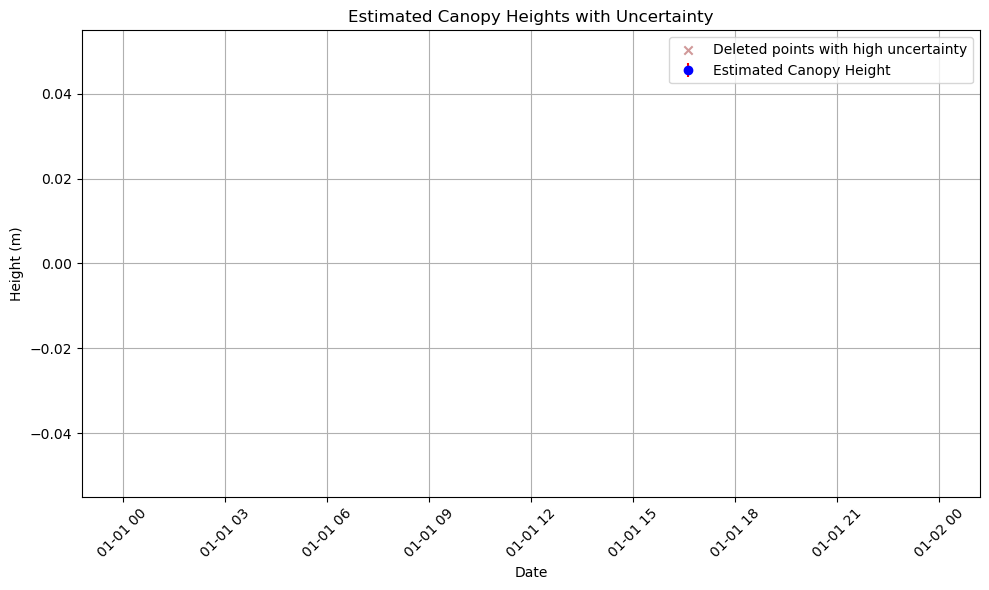

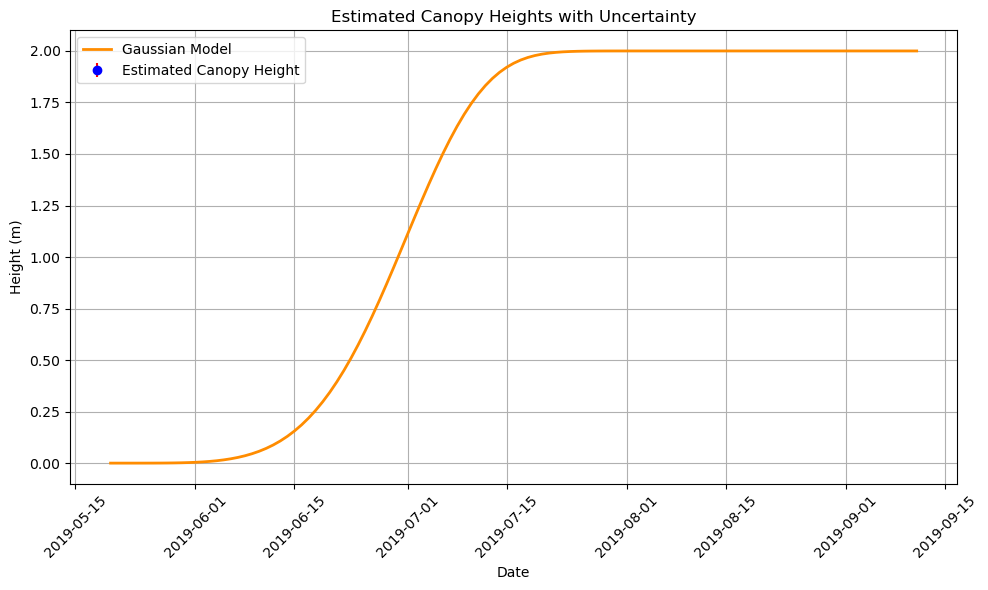

C:\Users\adadkhah\AppData\Local\Temp\ipykernel_16048\2162278004.py:4: RuntimeWarning: divide by zero encountered in log10
  d = 10 ** (0.979 * np.log10(h_c) - 0.154)


In [13]:
growing_season_half_hourly_df = UC1_tower_half_hourly_df.loc['2019']
canopy_height_plot(growing_season_half_hourly_df, zmax=5, d_hr=27)
maturity_day_after_planting, max_Canopy_height, dates = fit_canopy_height(growing_season_half_hourly_df,
                                                                   maturity_day_after_planting=76,
                                                                   max_Canopy_height=2,
                                                                   zmax=5, d_hr=27)


# and finally saving the estimated canopy height
Estimated_canopy_height = gaussian_fit((dates - dates.min()).days.tolist(),0,
                                       maturity_day_after_planting,
                                       max_Canopy_height)

UC1_tower_FFP_inputs_df_2019 = prepare_inputs_for_FFP_clim(growing_season_half_hourly_df, Estimated_canopy_height)

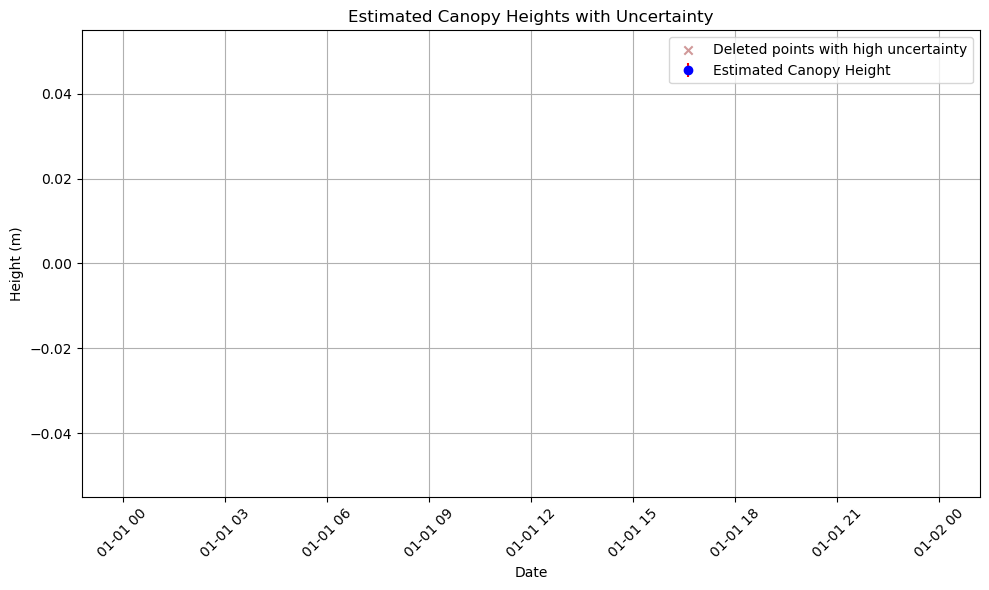

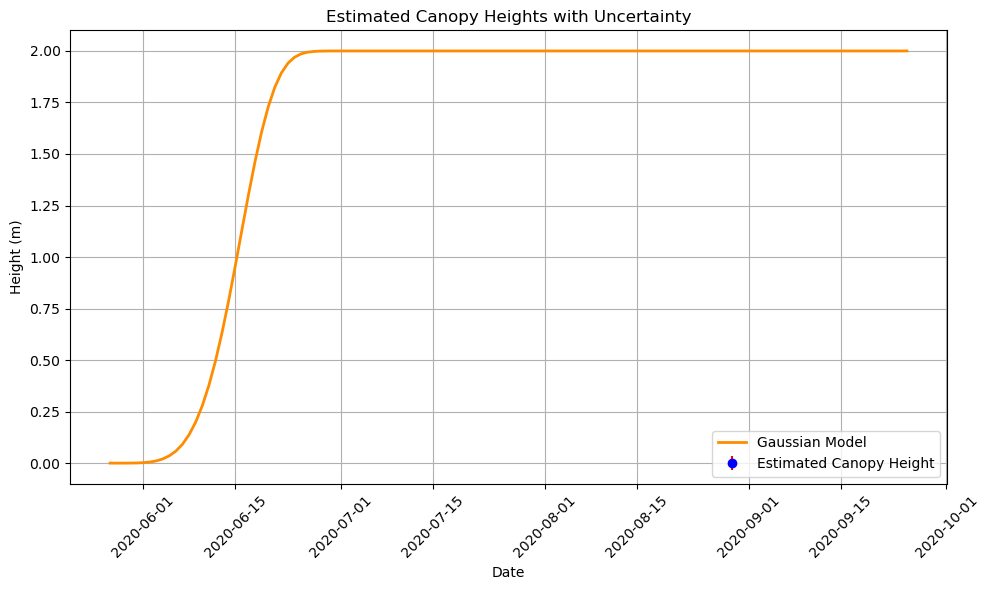

In [15]:
growing_season_half_hourly_df = UC1_tower_half_hourly_df.loc['2020']
canopy_height_plot(growing_season_half_hourly_df, zmax=5, d_hr=27)
maturity_day_after_planting, max_Canopy_height, dates = fit_canopy_height(growing_season_half_hourly_df,
                                                                   maturity_day_after_planting=36,
                                                                   max_Canopy_height=2,
                                                                   zmax=5, d_hr=27)


# and finally saving the estimated canopy height
Estimated_canopy_height = gaussian_fit((dates - dates.min()).days.tolist(),1,
                                       maturity_day_after_planting,
                                       max_Canopy_height)

UC1_tower_FFP_inputs_df_2020 = prepare_inputs_for_FFP_clim(growing_season_half_hourly_df, Estimated_canopy_height)

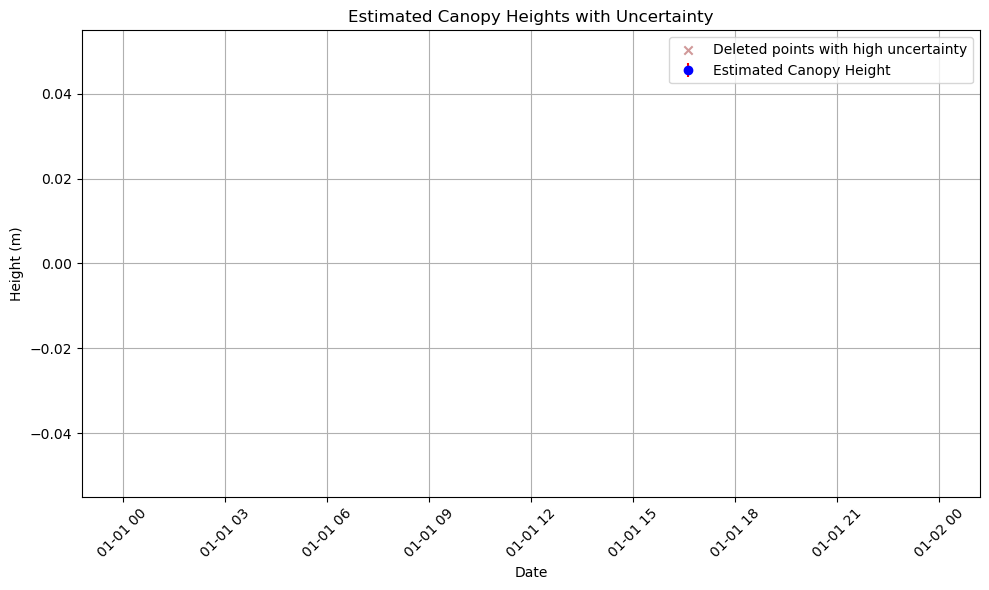

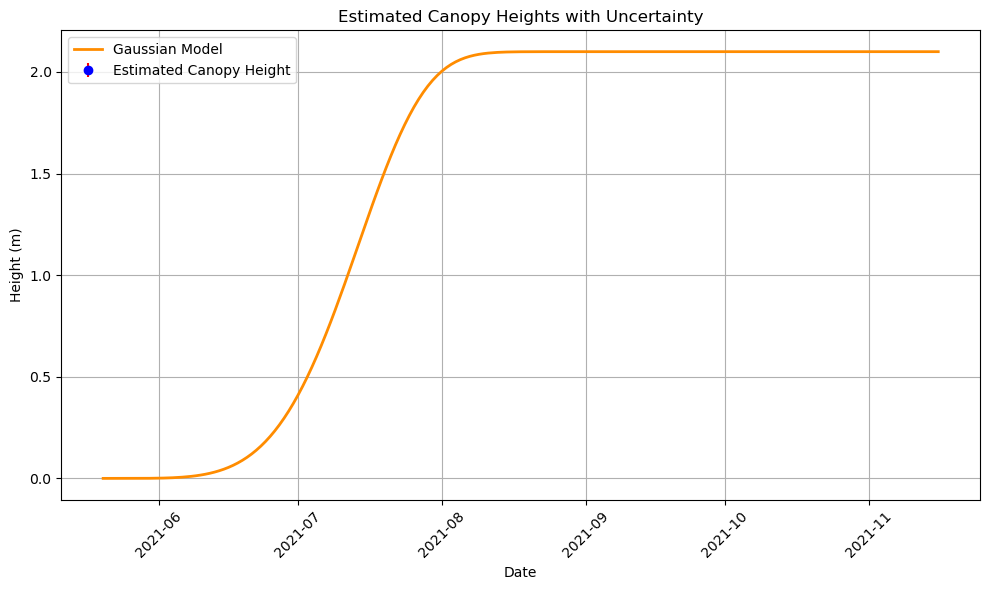

C:\Users\adadkhah\AppData\Local\Temp\ipykernel_16048\2162278004.py:4: RuntimeWarning: divide by zero encountered in log10
  d = 10 ** (0.979 * np.log10(h_c) - 0.154)


In [16]:
growing_season_half_hourly_df = UC1_tower_half_hourly_df.loc['2021']
canopy_height_plot(growing_season_half_hourly_df, zmax=5, d_hr=27)
maturity_day_after_planting, max_Canopy_height, dates = fit_canopy_height(growing_season_half_hourly_df,
                                                                   maturity_day_after_planting=100,
                                                                   max_Canopy_height=2.1,
                                                                   zmax=5, d_hr=27)


# and finally saving the estimated canopy height
Estimated_canopy_height = gaussian_fit((dates - dates.min()).days.tolist(),0,
                                       maturity_day_after_planting,
                                       max_Canopy_height)

UC1_tower_FFP_inputs_df_2021 = prepare_inputs_for_FFP_clim(growing_season_half_hourly_df, Estimated_canopy_height)

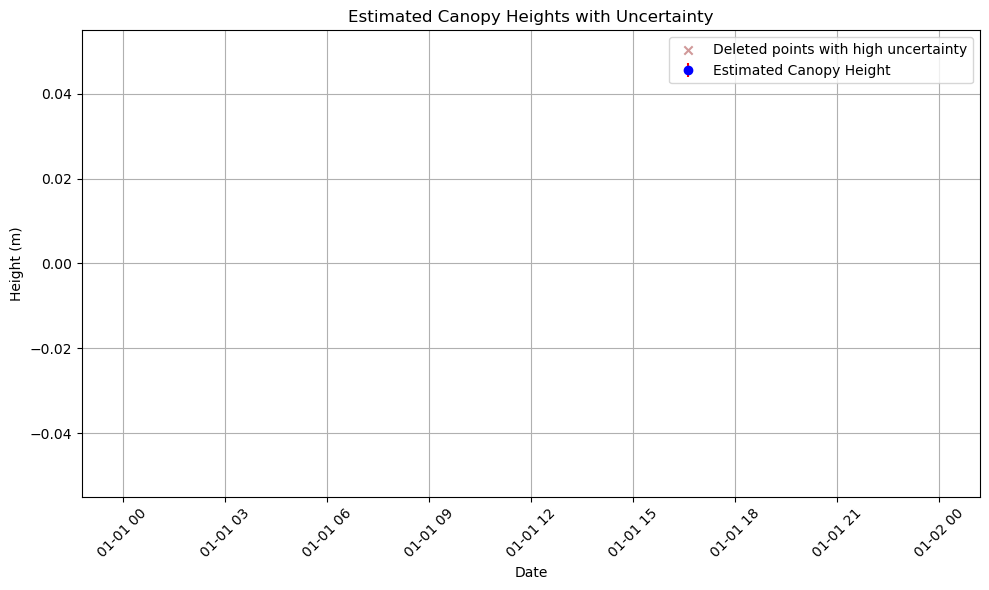

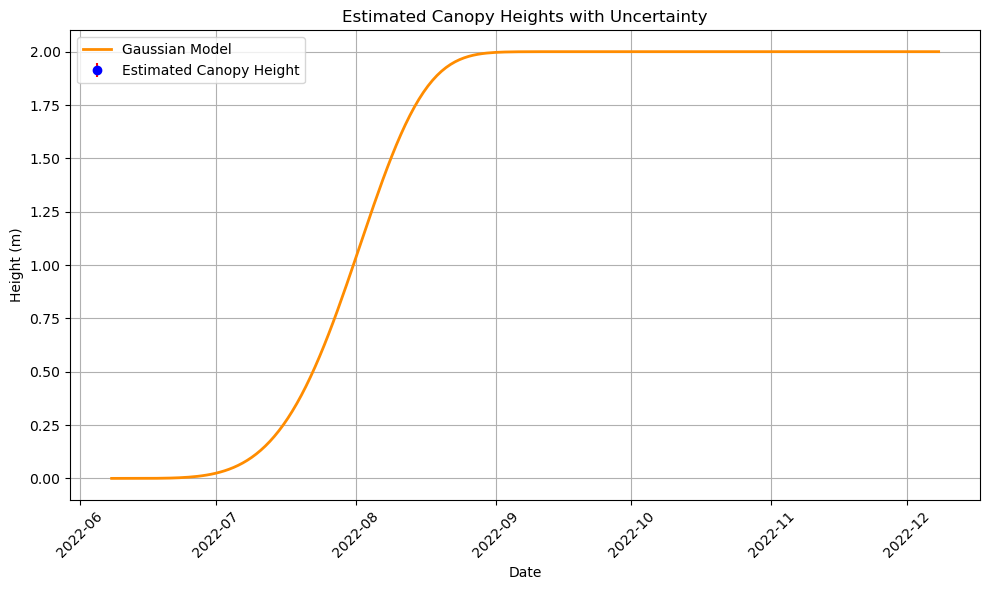

C:\Users\adadkhah\AppData\Local\Temp\ipykernel_16048\2162278004.py:4: RuntimeWarning: divide by zero encountered in log10
  d = 10 ** (0.979 * np.log10(h_c) - 0.154)


In [17]:
growing_season_half_hourly_df = UC1_tower_half_hourly_df.loc['2022']
canopy_height_plot(growing_season_half_hourly_df, zmax=5, d_hr=27)
maturity_day_after_planting, max_Canopy_height, dates = fit_canopy_height(growing_season_half_hourly_df,
                                                                   maturity_day_after_planting=100,
                                                                   max_Canopy_height=2,
                                                                   zmax=5, d_hr=27)


# and finally saving the estimated canopy height for the season 2021
Estimated_canopy_height = gaussian_fit((dates - dates.min()).days.tolist(),0,
                                       maturity_day_after_planting,
                                       max_Canopy_height)

UC1_tower_FFP_inputs_df_2022 = prepare_inputs_for_FFP_clim(growing_season_half_hourly_df, Estimated_canopy_height)

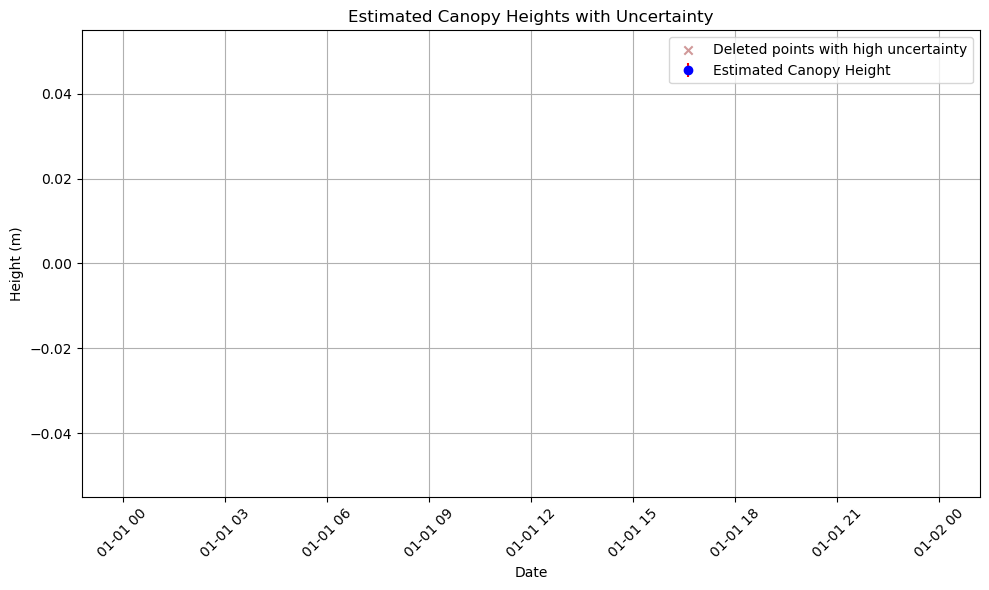

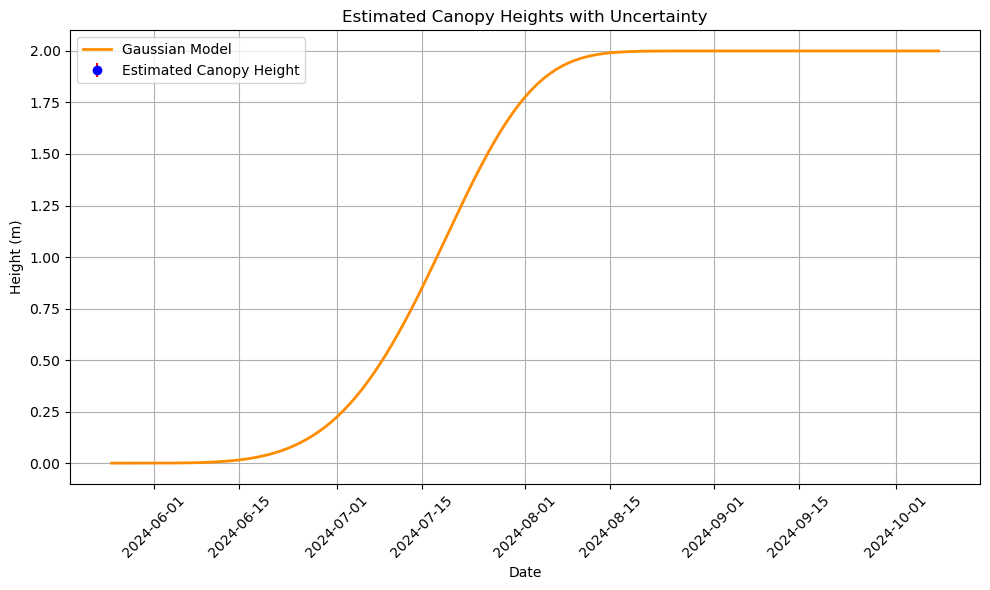

C:\Users\adadkhah\AppData\Local\Temp\ipykernel_16048\2162278004.py:4: RuntimeWarning: divide by zero encountered in log10
  d = 10 ** (0.979 * np.log10(h_c) - 0.154)


In [18]:
growing_season_half_hourly_df = UC1_tower_half_hourly_df.loc['2024']
canopy_height_plot(growing_season_half_hourly_df, zmax=5, d_hr=27)
maturity_day_after_planting, max_Canopy_height, dates = fit_canopy_height(growing_season_half_hourly_df,
                                                                   maturity_day_after_planting=100,
                                                                   max_Canopy_height=2,
                                                                   zmax=5, d_hr=27)


# and finally saving the estimated canopy height for the season 2021
Estimated_canopy_height = gaussian_fit((dates - dates.min()).days.tolist(),0,
                                       maturity_day_after_planting,
                                       max_Canopy_height)

UC1_tower_FFP_inputs_df_2024 = prepare_inputs_for_FFP_clim(growing_season_half_hourly_df, Estimated_canopy_height)

### UC2

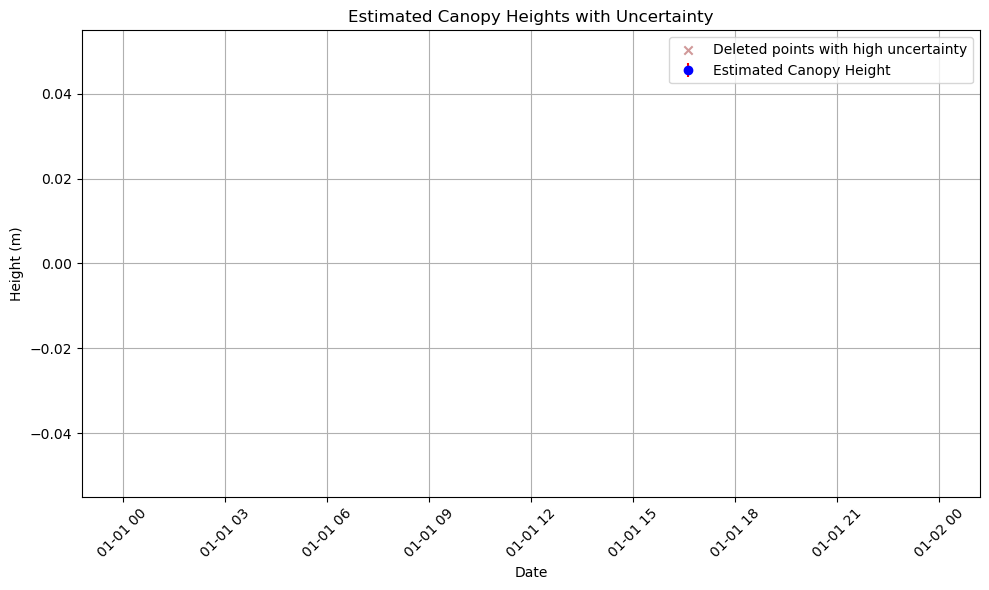

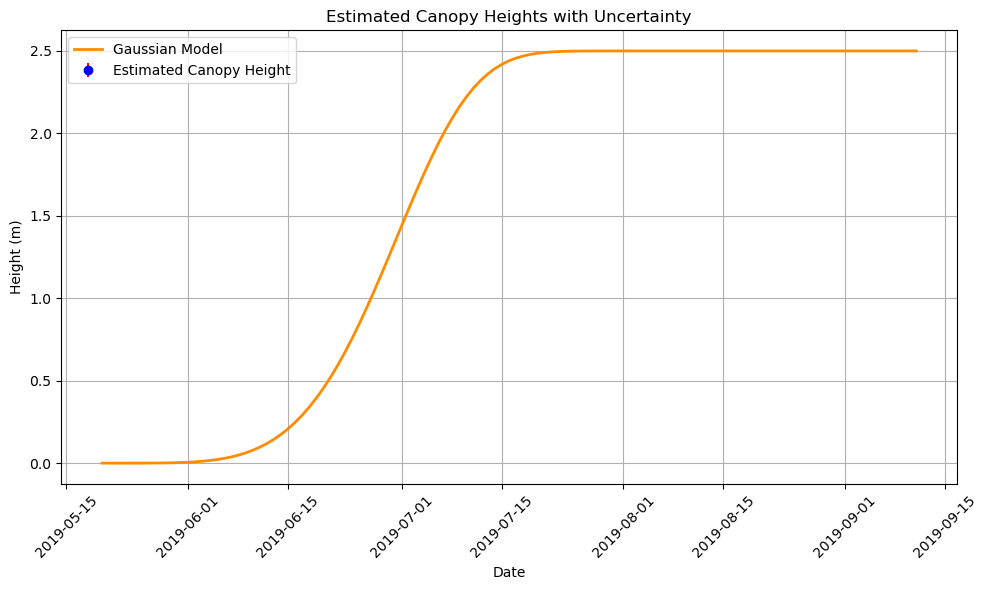

C:\Users\adadkhah\AppData\Local\Temp\ipykernel_16048\2162278004.py:4: RuntimeWarning: divide by zero encountered in log10
  d = 10 ** (0.979 * np.log10(h_c) - 0.154)


In [19]:
growing_season_half_hourly_df = UC2_tower_half_hourly_df.loc['2019']
canopy_height_plot(growing_season_half_hourly_df, zmax=5, d_hr=27)
maturity_day_after_planting, max_Canopy_height, dates = fit_canopy_height(growing_season_half_hourly_df,
                                                                   maturity_day_after_planting=75,
                                                                   max_Canopy_height=2.5,
                                                                   zmax=5, d_hr=27)


# and finally saving the estimated canopy height
Estimated_canopy_height = gaussian_fit((dates - dates.min()).days.tolist(),0,
                                       maturity_day_after_planting,
                                       max_Canopy_height)

UC2_tower_FFP_inputs_df_2019 = prepare_inputs_for_FFP_clim(growing_season_half_hourly_df, Estimated_canopy_height)

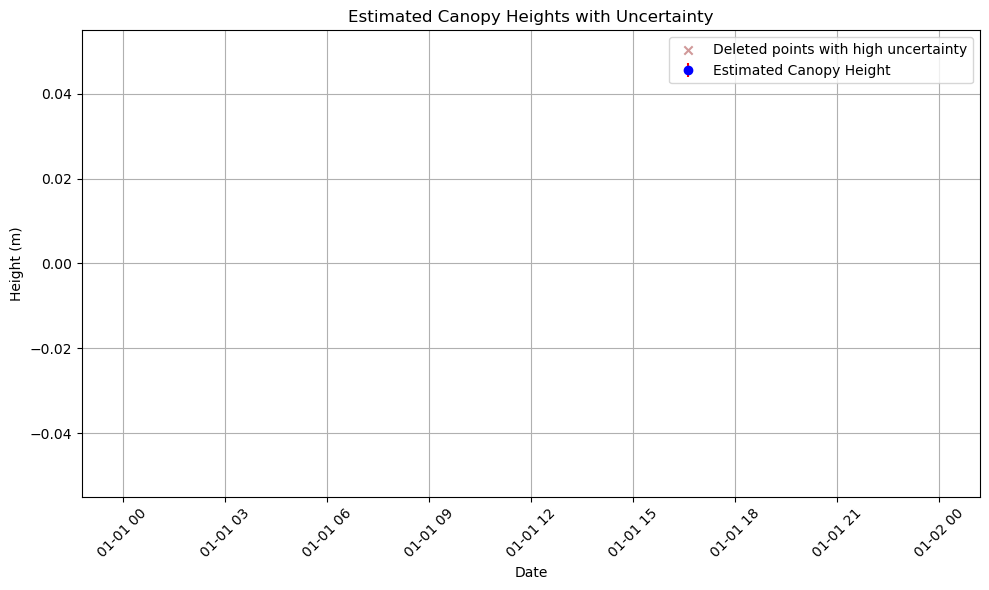

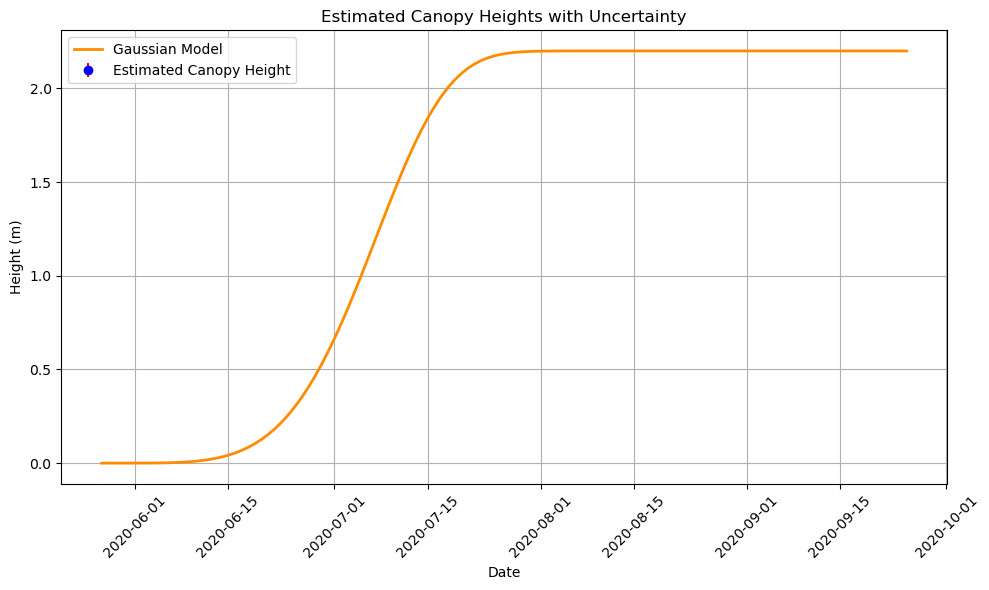

C:\Users\adadkhah\AppData\Local\Temp\ipykernel_16048\2162278004.py:4: RuntimeWarning: divide by zero encountered in log10
  d = 10 ** (0.979 * np.log10(h_c) - 0.154)


In [20]:
growing_season_half_hourly_df = UC2_tower_half_hourly_df.loc['2020']
canopy_height_plot(growing_season_half_hourly_df, zmax=5, d_hr=27)
maturity_day_after_planting, max_Canopy_height, dates = fit_canopy_height(growing_season_half_hourly_df,
                                                                   maturity_day_after_planting=75,
                                                                   max_Canopy_height=2.2,
                                                                   zmax=5, d_hr=27)


# and finally saving the estimated canopy height
Estimated_canopy_height = gaussian_fit((dates - dates.min()).days.tolist(),0,
                                       maturity_day_after_planting,
                                       max_Canopy_height)

UC2_tower_FFP_inputs_df_2020 = prepare_inputs_for_FFP_clim(growing_season_half_hourly_df, Estimated_canopy_height)

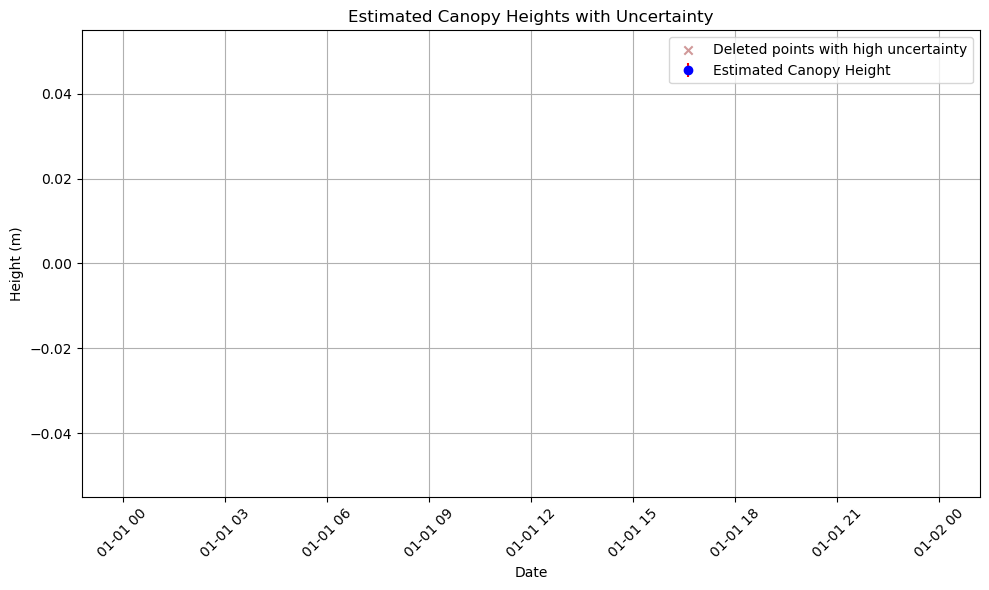

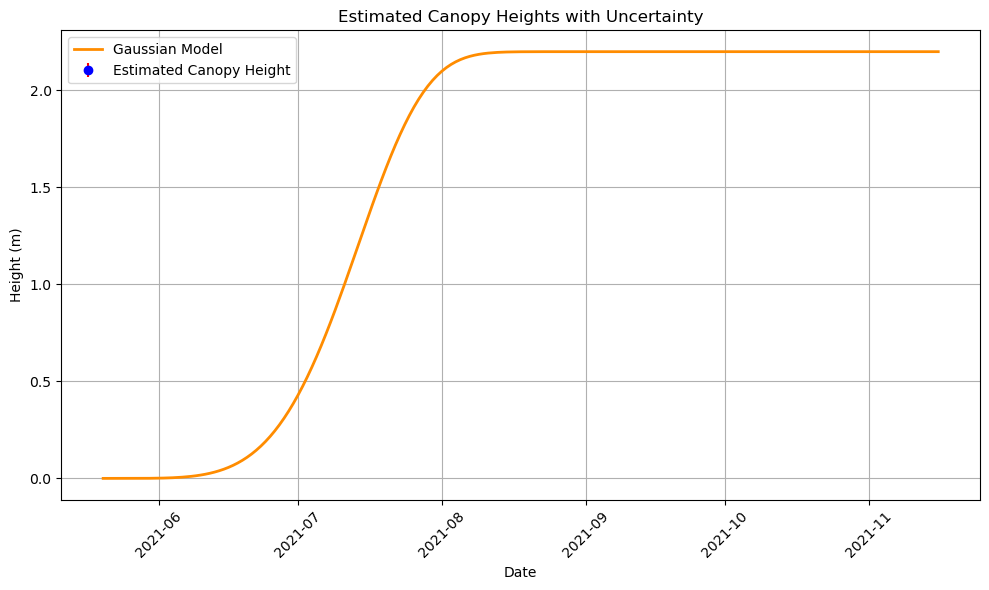

C:\Users\adadkhah\AppData\Local\Temp\ipykernel_16048\2162278004.py:4: RuntimeWarning: divide by zero encountered in log10
  d = 10 ** (0.979 * np.log10(h_c) - 0.154)


In [21]:
growing_season_half_hourly_df = UC2_tower_half_hourly_df.loc['2021']
canopy_height_plot(growing_season_half_hourly_df, zmax=5, d_hr=27)
maturity_day_after_planting, max_Canopy_height, dates = fit_canopy_height(growing_season_half_hourly_df,
                                                                   maturity_day_after_planting=100,
                                                                   max_Canopy_height=2.2,
                                                                   zmax=5, d_hr=27)


# and finally saving the estimated canopy height
Estimated_canopy_height = gaussian_fit((dates - dates.min()).days.tolist(),0,
                                       maturity_day_after_planting,
                                       max_Canopy_height)

UC2_tower_FFP_inputs_df_2021 = prepare_inputs_for_FFP_clim(growing_season_half_hourly_df, Estimated_canopy_height)

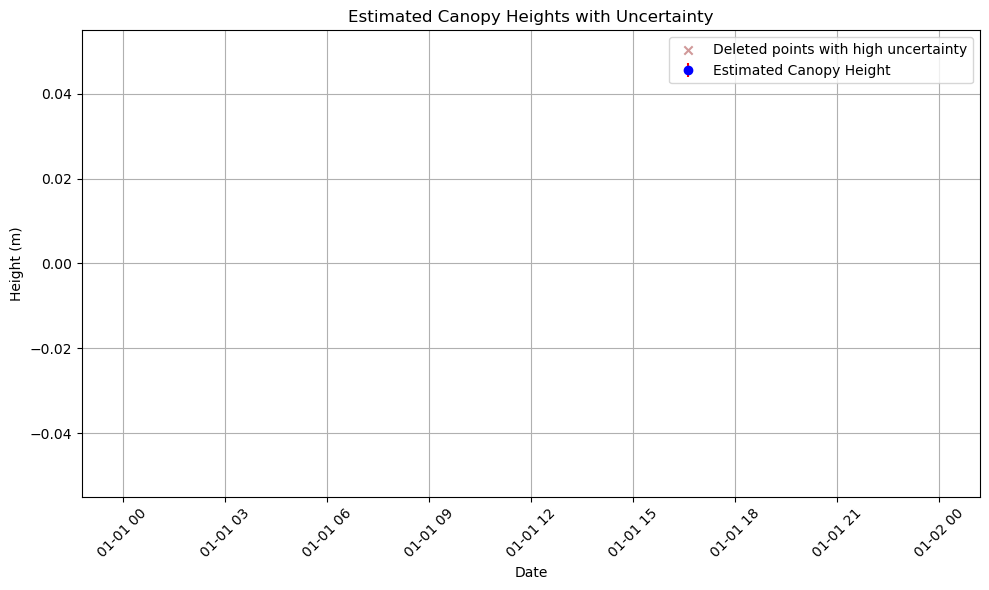

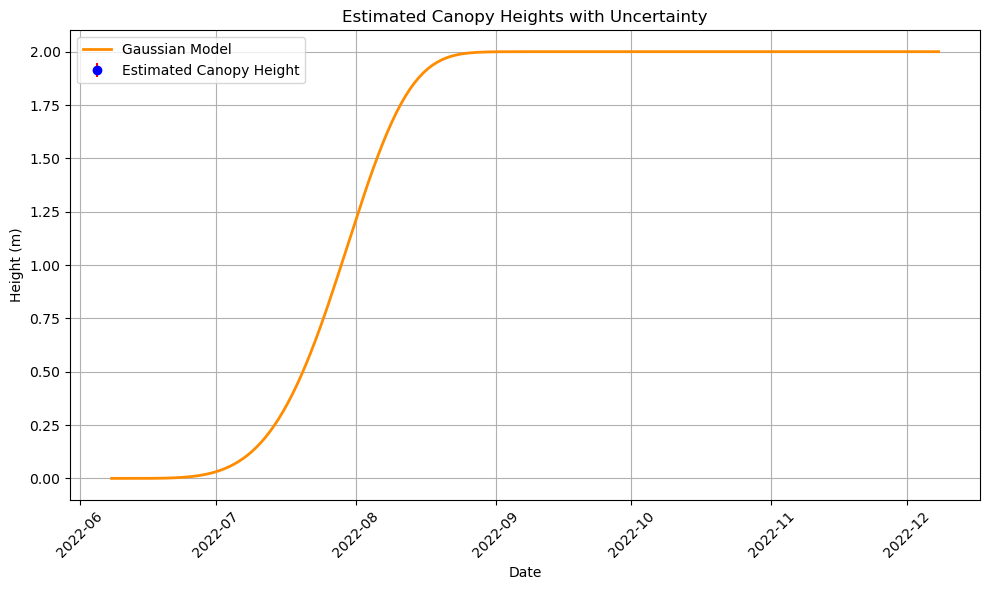

C:\Users\adadkhah\AppData\Local\Temp\ipykernel_16048\2162278004.py:4: RuntimeWarning: divide by zero encountered in log10
  d = 10 ** (0.979 * np.log10(h_c) - 0.154)


In [22]:
growing_season_half_hourly_df = UC2_tower_half_hourly_df.loc['2022']
canopy_height_plot(growing_season_half_hourly_df, zmax=5, d_hr=27)
maturity_day_after_planting, max_Canopy_height, dates = fit_canopy_height(growing_season_half_hourly_df,
                                                                   maturity_day_after_planting=95,
                                                                   max_Canopy_height=2,
                                                                   zmax=5, d_hr=27)


# and finally saving the estimated canopy height for the season 2021
Estimated_canopy_height = gaussian_fit((dates - dates.min()).days.tolist(),0,
                                       maturity_day_after_planting,
                                       max_Canopy_height)

UC2_tower_FFP_inputs_df_2022 = prepare_inputs_for_FFP_clim(growing_season_half_hourly_df, Estimated_canopy_height)

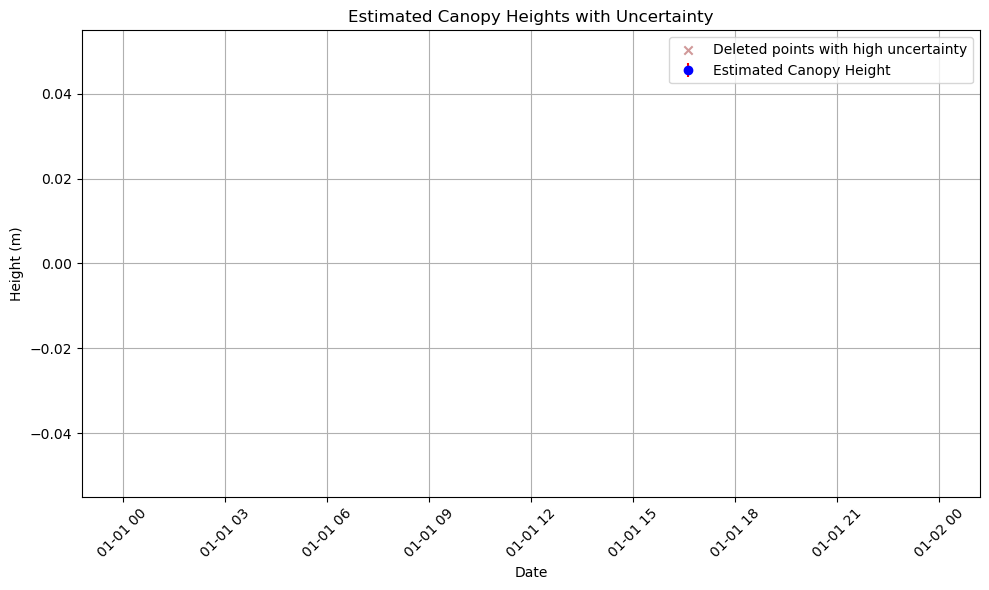

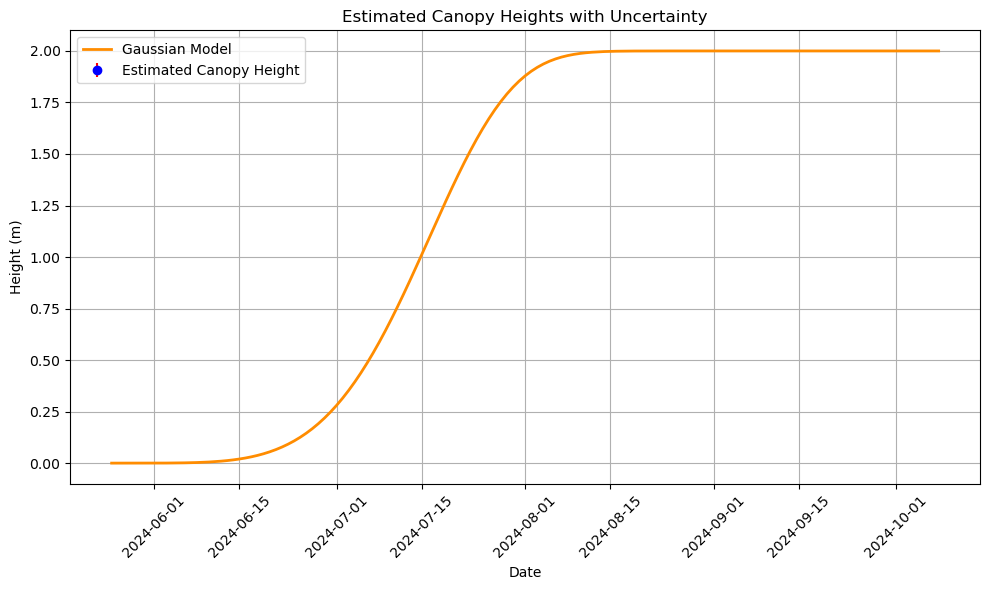

C:\Users\adadkhah\AppData\Local\Temp\ipykernel_16048\2162278004.py:4: RuntimeWarning: divide by zero encountered in log10
  d = 10 ** (0.979 * np.log10(h_c) - 0.154)


In [23]:
growing_season_half_hourly_df = UC2_tower_half_hourly_df.loc['2024']
canopy_height_plot(growing_season_half_hourly_df, zmax=5, d_hr=27)
maturity_day_after_planting, max_Canopy_height, dates = fit_canopy_height(growing_season_half_hourly_df,
                                                                   maturity_day_after_planting=95,
                                                                   max_Canopy_height=2,
                                                                   zmax=5, d_hr=27)


# and finally saving the estimated canopy height for the season 2021
Estimated_canopy_height = gaussian_fit((dates - dates.min()).days.tolist(),0,
                                       maturity_day_after_planting,
                                       max_Canopy_height)

UC2_tower_FFP_inputs_df_2024 = prepare_inputs_for_FFP_clim(growing_season_half_hourly_df, Estimated_canopy_height)

### HWB

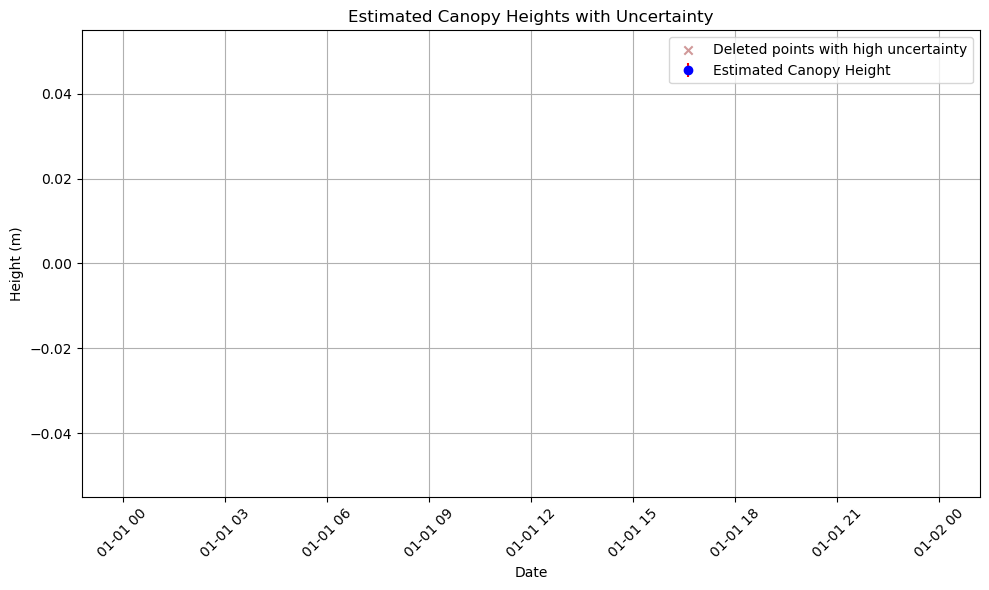

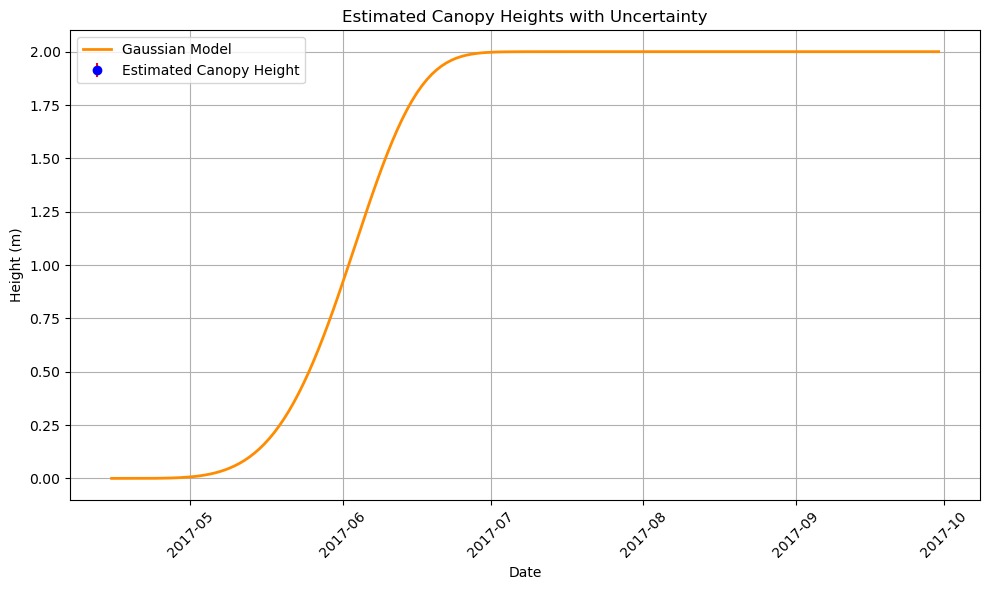

C:\Users\adadkhah\AppData\Local\Temp\ipykernel_16048\2162278004.py:4: RuntimeWarning: divide by zero encountered in log10
  d = 10 ** (0.979 * np.log10(h_c) - 0.154)


In [24]:
growing_season_half_hourly_df = HWB_tower_half_hourly_df.loc['2017']
canopy_height_plot(growing_season_half_hourly_df, zmax=5, d_hr=27)
maturity_day_after_planting, max_Canopy_height, dates = fit_canopy_height(growing_season_half_hourly_df,
                                                                   maturity_day_after_planting=90,
                                                                   max_Canopy_height=2,
                                                                   zmax=5, d_hr=27)


# and finally saving the estimated canopy height
Estimated_canopy_height = gaussian_fit((dates - dates.min()).days.tolist(),0,
                                       maturity_day_after_planting,
                                       max_Canopy_height)

HWB_tower_FFP_inputs_df_2017 = prepare_inputs_for_FFP_clim(growing_season_half_hourly_df, Estimated_canopy_height)

## Save to directory

In [26]:
UC1_tower_FFP_inputs_df_2019.to_csv('UC1_tower_FFP_inputs_df_2019.csv')
UC1_tower_FFP_inputs_df_2020.to_csv('UC1_tower_FFP_inputs_df_2020.csv')
UC1_tower_FFP_inputs_df_2021.to_csv('UC1_tower_FFP_inputs_df_2021.csv')
UC1_tower_FFP_inputs_df_2022.to_csv('UC1_tower_FFP_inputs_df_2022.csv')
UC1_tower_FFP_inputs_df_2024.to_csv('UC1_tower_FFP_inputs_df_2024.csv')

UC2_tower_FFP_inputs_df_2019.to_csv('UC2_tower_FFP_inputs_df_2019.csv')
UC2_tower_FFP_inputs_df_2020.to_csv('UC2_tower_FFP_inputs_df_2020.csv')
UC2_tower_FFP_inputs_df_2021.to_csv('UC2_tower_FFP_inputs_df_2021.csv')
UC2_tower_FFP_inputs_df_2022.to_csv('UC2_tower_FFP_inputs_df_2022.csv')
UC2_tower_FFP_inputs_df_2024.to_csv('UC2_tower_FFP_inputs_df_2024.csv')

HWB_tower_FFP_inputs_df_2017.to_csv('HWB_tower_FFP_inputs_df_2017.csv')

In [27]:
UC2_tower_FFP_inputs_df_2024

,wind_speed,Boundary_layer,Obukhov_length,sigmav,ustar,wind_dir,canopy_height,disp_height,measure_height
TIMESTAMP_START,,,,,,,,,
2024-05-25 06:00:00,0.955511,2000,-1.21200,0.225214,0.055100,92.5210,0.0,0.000000,5.000000
2024-05-25 06:30:00,0.886502,2000,1931.74000,0.319840,0.112753,70.4115,0.0,0.000000,5.000000
2024-05-25 07:00:00,0.368212,2000,-50.46220,0.511438,0.147221,138.8430,0.0,0.000000,5.000000
2024-05-25 07:30:00,1.113630,2000,-0.05690,0.437197,0.032000,225.1780,0.0,0.000000,5.000000
2024-05-25 08:00:00,1.349950,2000,-1.98352,0.451715,0.143238,218.7980,0.0,0.000000,5.000000
...,...,...,...,...,...,...,...,...,...
2024-10-08 16:30:00,2.431520,2000,130.44600,0.553253,0.166903,264.1490,2.0,1.382638,3.617362
2024-10-08 17:00:00,1.952880,2000,23.24840,0.466228,0.110698,256.7380,2.0,1.382638,3.617362
2024-10-08 17:30:00,2.234660,2000,10.37900,0.284925,0.114529,263.8680,2.0,1.382638,3.617362
